<a href="https://colab.research.google.com/github/akshat01112001/ML_Assignment/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A - Naive Bayes Classifier to predict income

##  Data Preprocessing

In [ ]:
!pip install kmodes

In [ ]:
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
import random
import math
import re
import matplotlib.pyplot as plt

In [ ]:
with open("adult.data", "r") as input_file:
    with open("adult_cleaned.csv", "w") as output_file:
        for line in input_file:
            if "?" not in line:
                output_file.write(line)

In [ ]:
headerList = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','over 50K']
df = pd.read_csv('adult_cleaned.csv', names=headerList)

In [ ]:
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country','over 50K']

for col in cat_cols:
    values = df[col].unique()
    mapping = {value: i for i, value in enumerate(values)}
    df[col] = df[col].map(mapping)

## Naive Bayes Classifier

In [ ]:
X = df.drop('over 50K',axis=1)
y = df['over 50K']

# Splitting of dataset in training set and test set
test_size = 0.33
df = df.sample(frac=1).reset_index(drop=True)
train_data = df[:int(len(df)*(1-test_size))]
test_data = df[int(len(df)*(1-test_size)):]

In [ ]:
# Calculate class priors
class_priors = train_data['over 50K'].value_counts(normalize=True)

# Calculate mean and variance for each feature for each class
means = {}
variances = {}
for label in train_data['over 50K'].unique():
    subset = train_data[train_data['over 50K'] == label]
    means[label] = subset.drop('over 50K', axis=1).mean()
    variances[label] = subset.drop('over 50K', axis=1).var()

# Define the predict function
def predict(data_point, smoothing='none', alpha=1.0):
    likelihoods = {}
    for label in train_data['over 50K'].unique():
        class_prior = class_priors[label]
        likelihood = 1.0
        for i, feature in enumerate(data_point):
            if smoothing == 'additive':
                count = train_data[(train_data['over 50K'] == label) & (train_data.iloc[:, i] == feature)].shape[0]
                likelihood *= (count + alpha) / (train_data[train_data['over 50K'] == label].shape[0] + alpha * len(train_data.iloc[:, i].unique()))
            elif smoothing == 'lidstone':
                count = train_data[(train_data['over 50K'] == label) & (train_data.iloc[:, i] == feature)].shape[0]
                likelihood *= (count + alpha) / (train_data[train_data['over 50K'] == label].shape[0] + alpha * len(train_data.iloc[:, i].unique()))
            elif smoothing == 'dirichlet':
                prior = train_data[train_data['over 50K'] == label].iloc[:, i].value_counts(normalize=True)
                likelihood *= prior.get(feature, alpha) # use prior if feature is not present, and alpha for smoothing
            else:
                count = train_data[(train_data['over 50K'] == label) & (train_data.iloc[:, i] == feature)].shape[0]
                likelihood *= count / train_data[train_data['over 50K'] == label].shape[0]
        likelihoods[label] = likelihood * class_prior
    return max(likelihoods, key=likelihoods.get)

l_accuracy = []
l_precision = []
l_recall = []
l_f1 = []

# Calculate evaluation based on smoothing techniques
def evaluation(l_accuracy,l_precision,l_recall,l_f1,smoothing='none'):
    # Make predictions on the test set
    print(f"Smoothing technique: {smoothing}")
    predictions = []
    for i in range(len(test_data)):
        data_point = test_data.iloc[i].drop('over 50K')
        prediction = predict(data_point, smoothing)
        predictions.append(prediction)

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for i in range(len(test_data)):
        if test_data.iloc[i]['over 50K'] == predictions[i]:
            if predictions[i] == 1:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if predictions[i] == 1:
                false_positives += 1
            else:
                false_negatives += 1

    accuracy = (true_positives + true_negatives) / len(test_data)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)

    l_accuracy.append(accuracy)
    l_precision.append(precision)
    l_recall.append(recall)
    l_f1.append(f1)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print()

evaluation(l_accuracy,l_precision,l_recall,l_f1)
evaluation(l_accuracy,l_precision,l_recall,l_f1,'additive')
evaluation(l_accuracy,l_precision,l_recall,l_f1,'lidstone')
evaluation(l_accuracy,l_precision,l_recall,l_f1,'dirichlet')

Smoothing technique: none
Accuracy: 0.7695398834639341
Precision: 0.546555639666919
Recall: 0.29871741828713283
F1-score: 0.38630283574103796

Smoothing technique: additive
Accuracy: 0.8288125376732972
Precision: 0.6097936556821681
Recall: 0.819197352089367
F1-score: 0.6991525423728814

Smoothing technique: lidstone
Accuracy: 0.8288125376732972
Precision: 0.6097936556821681
Recall: 0.819197352089367
F1-score: 0.6991525423728814

Smoothing technique: dirichlet
Accuracy: 0.6342174000401849
Precision: 0.35734265734265735
Recall: 0.6342573438146463
F1-score: 0.4571343372595795



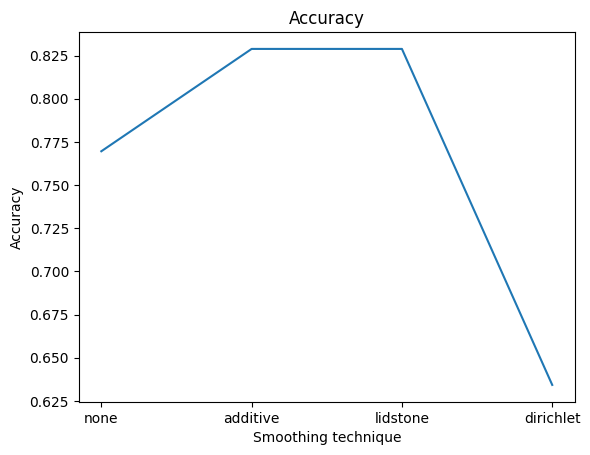

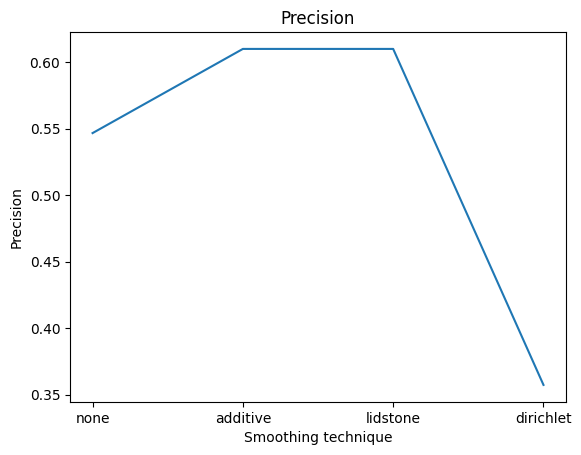

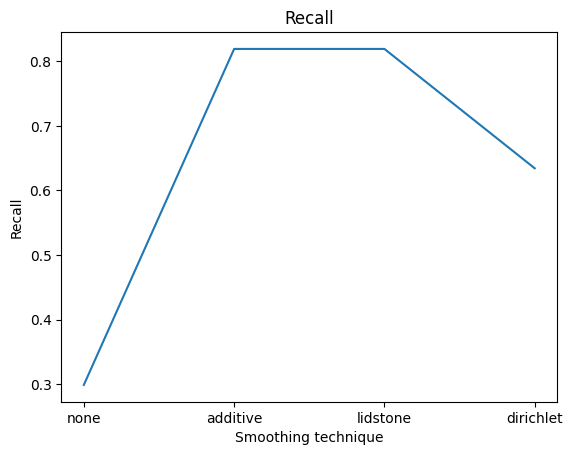

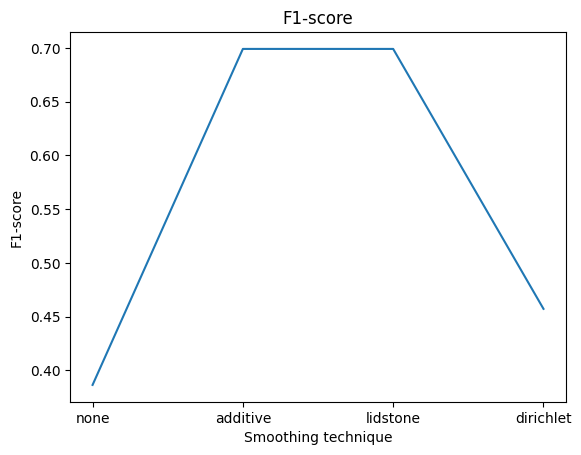

In [ ]:
types = ['none','additive','lidstone','dirichlet']

plt.plot(types, l_accuracy)
plt.xlabel('Smoothing technique')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

plt.plot(types, l_precision)
plt.xlabel('Smoothing technique')
plt.ylabel('Precision')
plt.title('Precision')
plt.show()

plt.plot(types, l_recall)
plt.xlabel('Smoothing technique')
plt.ylabel('Recall')
plt.title('Recall')
plt.show()

plt.plot(types, l_f1)
plt.xlabel('Smoothing technique')
plt.ylabel('F1-score')
plt.title('F1-score')
plt.show()

## Logistic Regression

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return y_predicted_cls
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [ ]:
lr = LogisticRegression()
lr.fit(train_data.drop('over 50K', axis=1), train_data['over 50K'])
y_pred = lr.predict(test_data.drop('over 50K', axis=1))
y_true = test_data['over 50K']

true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for i in range(len(test_data)):
    if test_data.iloc[i]['over 50K'] == y_pred[i]:
        if y_pred[i] == 1:
            true_positives += 1
        else:
            true_negatives += 1
    else:
        if y_pred[i] == 1:
            false_positives += 1
        else:
            false_negatives += 1

accuracy = (true_positives + true_negatives) / len(test_data)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

# print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

<ipython-input-13-2b474c27e810>:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-13-2b474c27e810>:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 0.7666264818163553
Precision: 0.930379746835443
Recall: 0.05978039853599024
F1-score: 0.11234237676729078


## K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# create KNN classifier object
knn = KNeighborsClassifier(n_neighbors=4)

# train the classifier on the training set
knn.fit(train_data.drop('over 50K', axis=1), train_data['over 50K'])

# make predictions on the testing set
y_pred = knn.predict(test_data.drop('over 50K', axis=1))

# calculate the eva;uation metrics of the model
accuracy = accuracy_score(test_data['over 50K'], y_pred)
precision = precision_score(test_data['over 50K'], y_pred, average='weighted')
recall = recall_score(test_data['over 50K'], y_pred, average='weighted')
f1 = f1_score(test_data['over 50K'], y_pred, average='weighted')

# print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7793800762473064
Precision: 0.7558713358004457
Recall: 0.7793800762473064
F1-score: 0.7435781681570786


# Part B - Building a Basic Neural Network for Image Classification

## Using ADAM optimisation

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2467 - accuracy: 0.9276 - val_loss: 0.1234 - val_accuracy: 0.9622
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1090 - accuracy: 0.9668 - val_loss: 0.0965 - val_accuracy: 0.9709
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.0893 - val_accuracy: 0.9728
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0593 - accuracy: 0.9818 - val_loss: 0.0875 - val_accuracy: 0.9731
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0472 - accuracy: 0.9852 - val_loss: 0.0772 - val_accuracy: 0.9757
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0391 - accuracy: 0.9873 - val_loss: 0.0813 - val_accuracy: 0.9752
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4639 - accuracy: 0.8791 - val_loss: 0.2157 - val_accuracy: 0.9375
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1808 - accuracy: 0.9467 - val_loss: 0.1462 - val_accuracy: 0.9567
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1287 - accuracy: 0.9619 - val_loss: 0.1213 - val_accuracy: 0.9637
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0985 - accuracy: 0.9708 - val_loss: 0.1020 - val_accuracy: 0.9696
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0776 - accuracy: 0.9766 - val_loss: 0.0885 - val_accuracy: 0.9727
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0617 - accuracy: 0.9815 - val_loss: 0.0827 - val_accuracy: 0.9747
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0503 - accuracy: 0.9854 - val_loss: 0.0842 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2658 - accuracy: 0.9220 - val_loss: 0.1542 - val_accuracy: 0.9555
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1226 - accuracy: 0.9627 - val_loss: 0.1101 - val_accuracy: 0.9664
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.0880 - val_accuracy: 0.9718
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0619 - accuracy: 0.9800 - val_loss: 0.1082 - val_accuracy: 0.9665
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0474 - accuracy: 0.9851 - val_loss: 0.0767 - val_accuracy: 0.9740
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0816 - val_accuracy: 0.9748
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.1018 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2440 - accuracy: 0.9258 - val_loss: 0.1317 - val_accuracy: 0.9573
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1060 - accuracy: 0.9679 - val_loss: 0.1157 - val_accuracy: 0.9641
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.0918 - val_accuracy: 0.9724
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0613 - accuracy: 0.9813 - val_loss: 0.0902 - val_accuracy: 0.9728
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0516 - accuracy: 0.9835 - val_loss: 0.0839 - val_accuracy: 0.9749
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0422 - accuracy: 0.9868 - val_loss: 0.0842 - val_accuracy: 0.9771
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0365 - accuracy: 0.9880 - val_loss: 0.0797 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.5270 - accuracy: 0.8499 - val_loss: 0.2085 - val_accuracy: 0.9381
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1713 - accuracy: 0.9500 - val_loss: 0.1529 - val_accuracy: 0.9522
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1171 - accuracy: 0.9649 - val_loss: 0.1161 - val_accuracy: 0.9640
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0892 - accuracy: 0.9730 - val_loss: 0.0980 - val_accuracy: 0.9700
Epoch 5/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.0914 - val_accuracy: 0.9721
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0590 - accuracy: 0.9817 - val_loss: 0.0858 - val_accuracy: 0.9724
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0490 - accuracy: 0.9848 - val_loss: 0.0881 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2546 - accuracy: 0.9254 - val_loss: 0.1483 - val_accuracy: 0.9574
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1194 - accuracy: 0.9639 - val_loss: 0.1109 - val_accuracy: 0.9661
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0849 - accuracy: 0.9742 - val_loss: 0.0967 - val_accuracy: 0.9695
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0927 - val_accuracy: 0.9698
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.0911 - val_accuracy: 0.9711
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0418 - accuracy: 0.9861 - val_loss: 0.0859 - val_accuracy: 0.9752
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0336 - accuracy: 0.9889 - val_loss: 0.0906 - val_accurac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2230 - accuracy: 0.9332 - val_loss: 0.1001 - val_accuracy: 0.9688
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0942 - accuracy: 0.9703 - val_loss: 0.0915 - val_accuracy: 0.9713
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0643 - accuracy: 0.9800 - val_loss: 0.0711 - val_accuracy: 0.9767
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0476 - accuracy: 0.9851 - val_loss: 0.0972 - val_accuracy: 0.9719
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0376 - accuracy: 0.9877 - val_loss: 0.0966 - val_accuracy: 0.9729
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0312 - accuracy: 0.9895 - val_loss: 0.0850 - val_accuracy: 0.9772
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0276 - accuracy: 0.9907 - val_loss: 0.0769 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.4129 - accuracy: 0.8855 - val_loss: 0.2117 - val_accuracy: 0.9372
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1639 - accuracy: 0.9503 - val_loss: 0.1430 - val_accuracy: 0.9573
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1128 - accuracy: 0.9663 - val_loss: 0.1119 - val_accuracy: 0.9661
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0845 - accuracy: 0.9744 - val_loss: 0.0965 - val_accuracy: 0.9699
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0660 - accuracy: 0.9801 - val_loss: 0.0871 - val_accuracy: 0.9727
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0516 - accuracy: 0.9839 - val_loss: 0.0809 - val_accuracy: 0.9738
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.0780 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2520 - accuracy: 0.9245 - val_loss: 0.1473 - val_accuracy: 0.9560
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1162 - accuracy: 0.9649 - val_loss: 0.1166 - val_accuracy: 0.9669
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0775 - accuracy: 0.9758 - val_loss: 0.1025 - val_accuracy: 0.9661
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0562 - accuracy: 0.9822 - val_loss: 0.0749 - val_accuracy: 0.9765
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0826 - val_accuracy: 0.9765
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.0737 - val_accuracy: 0.9786
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0854 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2208 - accuracy: 0.9337 - val_loss: 0.1139 - val_accuracy: 0.9648
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0966 - accuracy: 0.9705 - val_loss: 0.0910 - val_accuracy: 0.9721
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0682 - accuracy: 0.9789 - val_loss: 0.0934 - val_accuracy: 0.9707
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0543 - accuracy: 0.9830 - val_loss: 0.0760 - val_accuracy: 0.9778
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0930 - val_accuracy: 0.9741
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0361 - accuracy: 0.9880 - val_loss: 0.0952 - val_accuracy: 0.9744
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0329 - accuracy: 0.9896 - val_loss: 0.0787 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4446 - accuracy: 0.8683 - val_loss: 0.1977 - val_accuracy: 0.9414
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1589 - accuracy: 0.9533 - val_loss: 0.1372 - val_accuracy: 0.9570
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1082 - accuracy: 0.9679 - val_loss: 0.0995 - val_accuracy: 0.9697
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0819 - accuracy: 0.9752 - val_loss: 0.0858 - val_accuracy: 0.9729
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0641 - accuracy: 0.9802 - val_loss: 0.0846 - val_accuracy: 0.9752
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0508 - accuracy: 0.9842 - val_loss: 0.0966 - val_accuracy: 0.9715
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0411 - accuracy: 0.9870 - val_loss: 0.0819 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2438 - accuracy: 0.9262 - val_loss: 0.1325 - val_accuracy: 0.9611
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1142 - accuracy: 0.9650 - val_loss: 0.1037 - val_accuracy: 0.9672
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0822 - accuracy: 0.9740 - val_loss: 0.0950 - val_accuracy: 0.9689
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0587 - accuracy: 0.9808 - val_loss: 0.0867 - val_accuracy: 0.9735
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0460 - accuracy: 0.9845 - val_loss: 0.1018 - val_accuracy: 0.9699
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.0864 - val_accuracy: 0.9744
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0325 - accuracy: 0.9895 - val_loss: 0.0957 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2805 - accuracy: 0.9207 - val_loss: 0.1549 - val_accuracy: 0.9529
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1277 - accuracy: 0.9625 - val_loss: 0.1173 - val_accuracy: 0.9622
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0895 - accuracy: 0.9737 - val_loss: 0.0905 - val_accuracy: 0.9720
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0679 - accuracy: 0.9794 - val_loss: 0.0906 - val_accuracy: 0.9734
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0534 - accuracy: 0.9836 - val_loss: 0.0787 - val_accuracy: 0.9757
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0431 - accuracy: 0.9863 - val_loss: 0.0786 - val_accuracy: 0.9764
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.0752 - val_accuracy:

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4271 - accuracy: 0.8921 - val_loss: 0.2376 - val_accuracy: 0.9331
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2048 - accuracy: 0.9421 - val_loss: 0.1736 - val_accuracy: 0.9483
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1527 - accuracy: 0.9561 - val_loss: 0.1376 - val_accuracy: 0.9590
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1203 - accuracy: 0.9652 - val_loss: 0.1205 - val_accuracy: 0.9637
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0982 - accuracy: 0.9715 - val_loss: 0.1078 - val_accuracy: 0.9662
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0822 - accuracy: 0.9768 - val_loss: 0.0952 - val_accuracy: 0.9703
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0694 - accuracy: 0.9801 - val_loss: 0.0906 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2816 - accuracy: 0.9171 - val_loss: 0.1675 - val_accuracy: 0.9507
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1359 - accuracy: 0.9610 - val_loss: 0.1147 - val_accuracy: 0.9647
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0919 - accuracy: 0.9734 - val_loss: 0.0930 - val_accuracy: 0.9713
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0657 - accuracy: 0.9813 - val_loss: 0.0878 - val_accuracy: 0.9729
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0493 - accuracy: 0.9856 - val_loss: 0.0760 - val_accuracy: 0.9763
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0375 - accuracy: 0.9892 - val_loss: 0.0733 - val_accuracy: 0.9765
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0282 - accuracy: 0.9921 - val_loss: 0.0821 - val_ac

## Using Stochastic Gradient Descent (SGD) optimisation

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2879 - accuracy: 0.9145 - val_loss: 0.1412 - val_accuracy: 0.9584
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1211 - accuracy: 0.9633 - val_loss: 0.1025 - val_accuracy: 0.9674
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0878 - accuracy: 0.9729 - val_loss: 0.0834 - val_accuracy: 0.9736
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0694 - accuracy: 0.9787 - val_loss: 0.0954 - val_accuracy: 0.9703
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0553 - accuracy: 0.9829 - val_loss: 0.0830 - val_accuracy: 0.9743
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0467 - accuracy: 0.9856 - val_loss: 0.0785 - val_accuracy: 0.9759
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.0756 - val_accurac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9208 - accuracy: 0.7338 - val_loss: 0.3660 - val_accuracy: 0.8978
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3292 - accuracy: 0.9057 - val_loss: 0.2773 - val_accuracy: 0.9207
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2684 - accuracy: 0.9220 - val_loss: 0.2369 - val_accuracy: 0.9312
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2299 - accuracy: 0.9324 - val_loss: 0.2090 - val_accuracy: 0.9371
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2001 - accuracy: 0.9411 - val_loss: 0.1856 - val_accuracy: 0.9453
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1766 - accuracy: 0.9484 - val_loss: 0.1716 - val_accuracy: 0.9503
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1574 - accuracy: 0.9535 - val_loss: 0.1552 - val_accur

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.3016 - accuracy: 0.9114 - val_loss: 0.1721 - val_accuracy: 0.9500
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1484 - accuracy: 0.9574 - val_loss: 0.1285 - val_accuracy: 0.9610
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1063 - accuracy: 0.9675 - val_loss: 0.1011 - val_accuracy: 0.9684
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0810 - accuracy: 0.9759 - val_loss: 0.0891 - val_accuracy: 0.9716
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0653 - accuracy: 0.9806 - val_loss: 0.0762 - val_accuracy: 0.9760
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0545 - accuracy: 0.9832 - val_loss: 0.0778 - val_accuracy: 0.9756
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0449 - accuracy: 0.9865 - val_loss: 0.0731 - val_accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2957 - accuracy: 0.9079 - val_loss: 0.1357 - val_accuracy: 0.9577
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1188 - accuracy: 0.9637 - val_loss: 0.1070 - val_accuracy: 0.9666
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0853 - accuracy: 0.9732 - val_loss: 0.1006 - val_accuracy: 0.9670
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0668 - accuracy: 0.9792 - val_loss: 0.1027 - val_accuracy: 0.9691
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0532 - accuracy: 0.9832 - val_loss: 0.0938 - val_accuracy: 0.9732
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0776 - val_accuracy: 0.9764
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0347 - accuracy: 0.9889 - val_loss: 0.0845 - val_accurac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6029 - accuracy: 0.4457 - val_loss: 0.6508 - val_accuracy: 0.8106
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4969 - accuracy: 0.8580 - val_loss: 0.3794 - val_accuracy: 0.8923
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3363 - accuracy: 0.9025 - val_loss: 0.2913 - val_accuracy: 0.9156
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2589 - accuracy: 0.9250 - val_loss: 0.2243 - val_accuracy: 0.9342
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2106 - accuracy: 0.9394 - val_loss: 0.1923 - val_accuracy: 0.9441
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1785 - accuracy: 0.9483 - val_loss: 0.1909 - val_accuracy: 0.9453
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1540 - accuracy: 0.9548 - val_loss: 0.1520 - val_accura

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2876 - accuracy: 0.9143 - val_loss: 0.1653 - val_accuracy: 0.9504
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1328 - accuracy: 0.9596 - val_loss: 0.1098 - val_accuracy: 0.9655
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0928 - accuracy: 0.9714 - val_loss: 0.0975 - val_accuracy: 0.9690
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0706 - accuracy: 0.9780 - val_loss: 0.0913 - val_accuracy: 0.9694
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0573 - accuracy: 0.9818 - val_loss: 0.0779 - val_accuracy: 0.9755
Epoch 6/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0453 - accuracy: 0.9862 - val_loss: 0.0753 - val_accuracy: 0.9771
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0363 - accuracy: 0.9891 - val_loss: 0.0689 - val_accurac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
  76/1875 [>.............................] - ETA: 7s - loss: 1.3552 - accuracy: 0.5950

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5531 - accuracy: 0.4543 - val_loss: 0.6215 - val_accuracy: 0.8197
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4680 - accuracy: 0.8633 - val_loss: 0.3707 - val_accuracy: 0.8926
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3375 - accuracy: 0.9031 - val_loss: 0.2926 - val_accuracy: 0.9138
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2729 - accuracy: 0.9207 - val_loss: 0.2428 - val_accuracy: 0.9302
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2253 - accuracy: 0.9348 - val_loss: 0.2081 - val_accuracy: 0.9375
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1908 - accuracy: 0.9444 - val_loss: 0.1821 - val_accuracy: 0.9473
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1641 - accuracy: 0.9523 - val_loss: 0.1550 - val_accuracy:

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2835 - accuracy: 0.9166 - val_loss: 0.1578 - val_accuracy: 0.9515
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1340 - accuracy: 0.9600 - val_loss: 0.1114 - val_accuracy: 0.9646
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0947 - accuracy: 0.9702 - val_loss: 0.0992 - val_accuracy: 0.9694
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0710 - accuracy: 0.9779 - val_loss: 0.0825 - val_accuracy: 0.9732
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0552 - accuracy: 0.9828 - val_loss: 0.0800 - val_accuracy: 0.9735
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.0712 - val_accuracy: 0.9775
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.0749 - val_accuracy:

## Using Root Mean Square (RMS) Propagation optimisation

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2385 - accuracy: 0.9303 - val_loss: 0.1426 - val_accuracy: 0.9548
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1075 - accuracy: 0.9677 - val_loss: 0.1089 - val_accuracy: 0.9681
Epoch 3/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0791 - accuracy: 0.9768 - val_loss: 0.0983 - val_accuracy: 0.9710
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0646 - accuracy: 0.9809 - val_loss: 0.0963 - val_accuracy: 0.9726
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0550 - accuracy: 0.9843 - val_loss: 0.0942 - val_accuracy: 0.9753
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0458 - accuracy: 0.9867 - val_loss: 0.1064 - val_accuracy: 0.9737
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0417 - accuracy: 0.9885 - val_loss: 0.1084 - val_a

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: 0.4559 - accuracy: 0.8778 - val_loss: 0.2117 - val_accuracy: 0.9353
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1865 - accuracy: 0.9436 - val_loss: 0.1585 - val_accuracy: 0.9506
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1365 - accuracy: 0.9586 - val_loss: 0.1305 - val_accuracy: 0.9595
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 0.1057 - val_accuracy: 0.9676
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0903 - accuracy: 0.9731 - val_loss: 0.0935 - val_accuracy: 0.9696
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0765 - accuracy: 0.9769 - val_loss: 0.0893 - val_accuracy: 0.9717
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0665 - accuracy: 0.9803 - val_loss: 0.0876 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2692 - accuracy: 0.9208 - val_loss: 0.1597 - val_accuracy: 0.9509
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1275 - accuracy: 0.9617 - val_loss: 0.1059 - val_accuracy: 0.9674
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0900 - accuracy: 0.9729 - val_loss: 0.0891 - val_accuracy: 0.9716
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0691 - accuracy: 0.9789 - val_loss: 0.0808 - val_accuracy: 0.9752
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0550 - accuracy: 0.9827 - val_loss: 0.0746 - val_accuracy: 0.9764
Epoch 6/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.0776 - val_accuracy: 0.9763
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0369 - accuracy: 0.9888 - val_loss: 0.0807 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2446 - accuracy: 0.9261 - val_loss: 0.1434 - val_accuracy: 0.9578
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1104 - accuracy: 0.9675 - val_loss: 0.1086 - val_accuracy: 0.9686
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0835 - accuracy: 0.9758 - val_loss: 0.0853 - val_accuracy: 0.9770
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0690 - accuracy: 0.9804 - val_loss: 0.0943 - val_accuracy: 0.9765
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0609 - accuracy: 0.9830 - val_loss: 0.0959 - val_accuracy: 0.9778
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0555 - accuracy: 0.9846 - val_loss: 0.0976 - val_accuracy: 0.9803
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0504 - accuracy: 0.9865 - val_loss: 0.0985 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5951 - accuracy: 0.8223 - val_loss: 0.2754 - val_accuracy: 0.9147
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2039 - accuracy: 0.9393 - val_loss: 0.1606 - val_accuracy: 0.9521
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1438 - accuracy: 0.9574 - val_loss: 0.1239 - val_accuracy: 0.9624
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1143 - accuracy: 0.9657 - val_loss: 0.1223 - val_accuracy: 0.9645
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0953 - accuracy: 0.9716 - val_loss: 0.1002 - val_accuracy: 0.9709
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0821 - accuracy: 0.9758 - val_loss: 0.0961 - val_accuracy: 0.9717
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0722 - accuracy: 0.9786 - val_loss: 0.0906 - val_ac

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2606 - accuracy: 0.9220 - val_loss: 0.1582 - val_accuracy: 0.9536
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1230 - accuracy: 0.9633 - val_loss: 0.1307 - val_accuracy: 0.9616
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0874 - accuracy: 0.9729 - val_loss: 0.0980 - val_accuracy: 0.9712
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0675 - accuracy: 0.9793 - val_loss: 0.0825 - val_accuracy: 0.9744
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0528 - accuracy: 0.9833 - val_loss: 0.0984 - val_accuracy: 0.9719
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.0877 - val_accuracy: 0.9750
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.0930 - val_accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(150, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
test_loss, test_acc = model.evaluate(x_test, y_test)
# Compute the confusion matrix
confusion_matrix = np.zeros((10, 10), dtype=np.int32)
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1
print(f'Test accuracy: {test_acc}')
print("Confusion Matrix:\n", confusion_matrix)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2533 - accuracy: 0.9240 - val_loss: 0.1470 - val_accuracy: 0.9540
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1169 - accuracy: 0.9649 - val_loss: 0.1040 - val_accuracy: 0.9687
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0810 - accuracy: 0.9753 - val_loss: 0.1030 - val_accuracy: 0.9669
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0605 - accuracy: 0.9812 - val_loss: 0.0815 - val_accuracy: 0.9735
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0453 - accuracy: 0.9855 - val_loss: 0.0866 - val_accuracy: 0.9753
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.0878 - val_accuracy: 0.9763
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.0899 - val_accura